# Decision tree classifier: diabetes prediction

In [ ]:
# Handle imports up front - this shows people what tools we will be using
# throughout the notebook
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import uniform, randint
from sklearn import tree
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score. RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import mutual_info_classif, RFECV
from sklearn.model_selection import GridSearchCV


# This is a collection of custom functions I wrote for this notebook. I moved them
# into a separate module so that they can easily be reused and don't clutter up this notebook
import notebook_helper_functions

# Also, set some parameters that will be reused throughout the notebook

# Set random seed for notebook
random_seed=42

# Set train-test split fraction
testing_fraction=0.33

# Cross-validation method
cv_method=RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=random_seed)

# Default class weighting for decision trees
class_weights=None

## 1. Data acquisition

### 1.1. Load

In [2]:
# Load the data from the URL
data_df=pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/decision-tree-project-tutorial/main/diabetes.csv")
data_df.drop_duplicates().reset_index(drop=True, inplace=True)

### 1.2. Train-test split

In [3]:
# Split the data into training and testing, setting the random seed
# so that we get the same test-train split every time we run the notebook
training_df, testing_df=train_test_split(
    data_df,
    test_size=testing_fraction,
    random_state=random_seed
)

# Reset the indexes
training_df.reset_index(inplace=True, drop=True)
testing_df.reset_index(inplace=True, drop=True)

In [4]:
# Get features and labels
training_labels=training_df['Outcome']
training_features=training_df.drop('Outcome', axis=1)

### 1.3. Inspect the data

In [5]:
training_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 514 entries, 0 to 513
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               514 non-null    int64  
 1   Glucose                   514 non-null    int64  
 2   BloodPressure             514 non-null    int64  
 3   SkinThickness             514 non-null    int64  
 4   Insulin                   514 non-null    int64  
 5   BMI                       514 non-null    float64
 6   DiabetesPedigreeFunction  514 non-null    float64
 7   Age                       514 non-null    int64  
dtypes: float64(2), int64(6)
memory usage: 32.2 KB


In [6]:
training_labels.info()

<class 'pandas.core.series.Series'>
RangeIndex: 514 entries, 0 to 513
Series name: Outcome
Non-Null Count  Dtype
--------------  -----
514 non-null    int64
dtypes: int64(1)
memory usage: 4.1 KB


In [7]:
list(training_labels[:10])

[0, 0, 0, 1, 0, 0, 0, 1, 0, 0]

## 2. Baseline decision tree classifier

The data is now in a state which is sufficient to train a decision tree classifier. Let's go a head and see how it performs, the will set the baseline for comparison as we do EDA/feature engineering and model optimization.

In [8]:
# Run cross-validation
scores=cross_val_score(
    DecisionTreeClassifier(random_state=random_seed, class_weight=class_weights),
    training_features,
    training_labels,
    cv=cv_method,
    n_jobs=-1,
    scoring='accuracy'
)

# Collect the scores so we can plot and compare later
experiments={'Baseline': scores * 100}

print(f'Cross-validation accuracy: {(np.median(scores) * 100):.1f} +/- {(scores.std() * 100):.1f}%')

Cross-validation accuracy: 69.9 +/- 4.4%


Ok, so an accuracy of about 70% is the score to beat!

Fitted tree depth: 12

Feature importances:
 Pregnancies: 0.050
 Glucose: 0.406
 BloodPressure: 0.080
 SkinThickness: 0.045
 Insulin: 0.102
 BMI: 0.145
 DiabetesPedigreeFunction: 0.082
 Age: 0.089



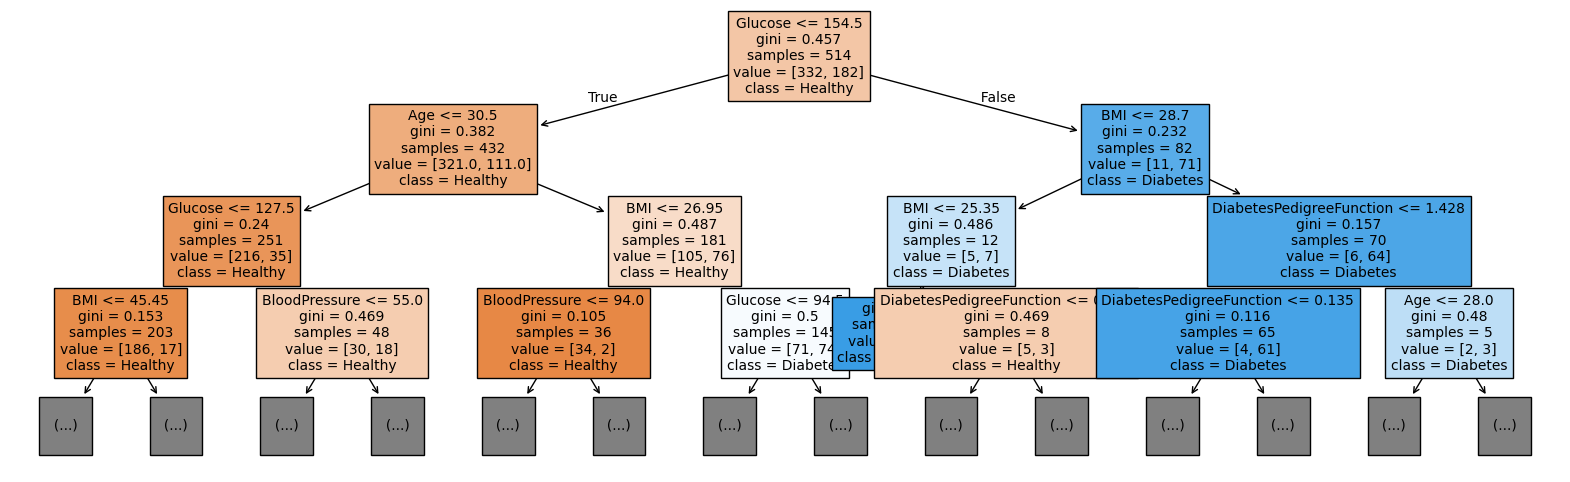

In [9]:
# For fun, let's take a look at the tree sklearn came up with
model=DecisionTreeClassifier(random_state=random_seed, class_weight=class_weights)
fit_result=model.fit(training_features, training_labels)

print(f'Fitted tree depth: {fit_result.tree_.max_depth}')
print('\nFeature importances:')

for feature, importance in zip(training_features.columns, fit_result.tree_.compute_feature_importances()):
    print(f' {feature}: {importance:.3f}')

print()

# Plot the first few levels of the tree
fig=plt.figure(figsize=(20,6))

tree.plot_tree(model,
    feature_names=list(training_features.columns),
    class_names=['Healthy', 'Diabetes'],
    filled=True,
    fontsize=10,
    max_depth=3
)

plt.show()

From the diagram we can see that the first split is on Glucose at a value of 154.5, etc.

## 3. EDA/feature engineering

Now, let's dig into the data and see what we can do to clean up and improve it.

### 3.1. Feature distributions

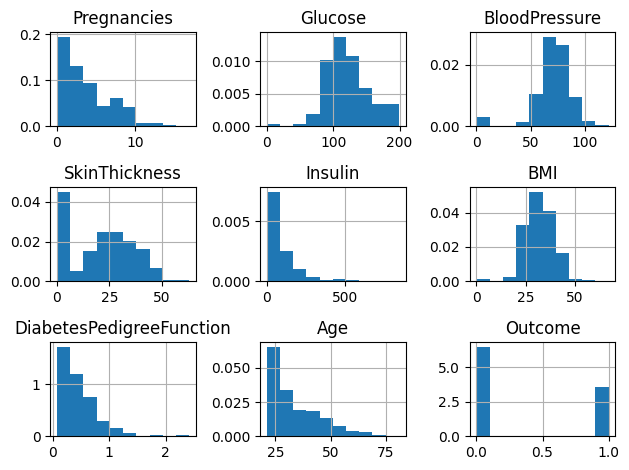

In [10]:
training_df.hist(density=True, layout=(3,3))
plt.tight_layout()
plt.show()

In [11]:
training_df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000
mean,3.782101,121.295720,69.984436,20.525292,79.237354,31.969844,0.473089,33.190661,0.354086
std,3.277187,32.358526,18.008763,15.501504,115.642548,7.649192,0.341989,11.731010,0.478701
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,64.000000,0.000000,0.000000,26.925000,0.244250,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,34.000000,32.000000,0.383500,29.000000,0.000000
75%,6.000000,140.000000,80.000000,32.000000,125.750000,36.500000,0.614500,41.000000,1.000000
max,17.000000,199.000000,122.000000,63.000000,846.000000,67.100000,2.420000,81.000000,1.000000


First weird observation... we have at least one record where everything except DPF and age is zero - I'm pretty sure that someone didn't have zero blood pressure or zero skin thickness! That's probably missing data. How much is there?

### 3.2. Missing values

Ok, if we were to remove rows that contain zero in one of 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin' or 'BMI', how much data would we have left?

In [12]:
# Features to look for zeros in
missing_data_features=['Glucose','BloodPressure','SkinThickness','Insulin','BMI']

# Remove rows that have at least one zeros, using a copy, in case we decide it's a bad idea
filtered_training_df=training_df.copy()
filtered_training_df[missing_data_features]=filtered_training_df[missing_data_features].replace({0:np.nan})
filtered_training_df.dropna(inplace=True)

filtered_training_df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,262.000000,262.000000,262.000000,262.000000,262.000000,262.000000,262.000000,262.000000,262.000000
mean,3.335878,124.019084,70.847328,28.904580,155.110687,32.856870,0.511737,30.832061,0.332061
std,3.124764,30.748074,12.670885,10.626832,120.283283,7.188289,0.349665,10.129546,0.471854
min,0.000000,56.000000,24.000000,10.000000,14.000000,18.200000,0.085000,21.000000,0.000000
25%,1.000000,100.000000,62.500000,21.000000,79.000000,27.500000,0.273000,23.000000,0.000000
50%,2.000000,120.000000,70.000000,28.500000,125.000000,32.800000,0.443500,27.000000,0.000000
75%,5.000000,143.000000,80.000000,36.000000,182.750000,37.175000,0.653000,36.000000,1.000000
max,17.000000,198.000000,110.000000,63.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Wow, ok - so that's almost half of our data! We can't just throw all of those examples away. Let's try a simple median imputation for each feature to fill in the missing values.

#### 3.2.1. Simple imputation

In [13]:
simple_imputed_training_features=training_features.copy()

for target_feature in missing_data_features:

    impute_data=simple_imputed_training_features[simple_imputed_training_features[target_feature] != 0][target_feature]
    target_feature_imputed_value=impute_data.median()
    imputed_data=simple_imputed_training_features[target_feature].replace({0:target_feature_imputed_value})
    simple_imputed_training_features[target_feature]=imputed_data

    print(f'{target_feature} imputed value: {target_feature_imputed_value:.1f}')

simple_imputed_training_features.describe()

Glucose imputed value: 118.0
BloodPressure imputed value: 72.0
SkinThickness imputed value: 29.0
Insulin imputed value: 125.0
BMI imputed value: 32.0


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000
mean,3.782101,122.214008,72.505837,28.762646,140.278210,32.281128,0.473089,33.190661
std,3.277187,30.522048,12.092761,8.535335,87.135766,6.960701,0.341989,11.731010
min,0.000000,44.000000,24.000000,8.000000,14.000000,18.200000,0.078000,21.000000
25%,1.000000,100.000000,64.000000,24.000000,120.000000,27.125000,0.244250,24.000000
50%,3.000000,118.000000,72.000000,29.000000,125.000000,32.000000,0.383500,29.000000
75%,6.000000,140.000000,80.000000,32.000000,125.750000,36.500000,0.614500,41.000000
max,17.000000,199.000000,122.000000,63.000000,846.000000,67.100000,2.420000,81.000000


Try the cross-validation again and see how we did.

In [14]:
# Run cross-validation
scores=cross_val_score(
    DecisionTreeClassifier(random_state=random_seed, class_weight=class_weights),
    simple_imputed_training_features,
    training_labels,
    cv=cv_method,
    n_jobs=-1,
    scoring='accuracy'
)

# Collect the scores so we can plot and compare later
experiments['Simple imputation']=scores * 100

print(f'Cross-validation accuracy: {(np.median(scores) * 100):.1f} +/- {(scores.std() * 100):.1f}%')

Cross-validation accuracy: 69.9 +/- 4.5%


No improvement. Let's try a little bit more advanced of an imputation strategy from scikit-learn:

#### 3.2.2. Scikit-learn IterativeImputer

In [15]:
# This function is being imported from notebook_helper_functions.py
iterative_imputed_training_features, imp, qt=notebook_helper_functions.impute(training_features, missing_data_features)

[IterativeImputer] Completing matrix with shape (514, 8)
[IterativeImputer] Completing matrix with shape (514, 8)


In [16]:
# Run cross-validation
scores=cross_val_score(
    DecisionTreeClassifier(random_state=random_seed, class_weight=class_weights),
    iterative_imputed_training_features,
    training_labels,
    cv=cv_method,
    n_jobs=-1,
    scoring='accuracy'
)

# Collect the scores so we can plot and compare later
experiments['Iterative imputation']=scores * 100

print(f'Cross-validation accuracy: {(np.median(scores) * 100):.1f} +/- {(scores.std() * 100):.1f}%')

Cross-validation accuracy: 70.2 +/- 4.7%


Good - better. Next, let's look at selecting features - do we need all of them?

### 3.3. Manual feature selection

First approach will be to look at the relationships within the features and the features and to target and use human judgement to decide which features to include.

#### 2.3.1. Feature cross-correlation

Let's take a look at the cross-correlation matrix for the training features and manually remove any that are highly correlated.

Have 8 features for plot:
 0: Pregnancies
 1: Glucose
 2: BloodPressure
 3: SkinThickness
 4: Insulin
 5: BMI
 6: DiabetesPedigreeFunction
 7: Age


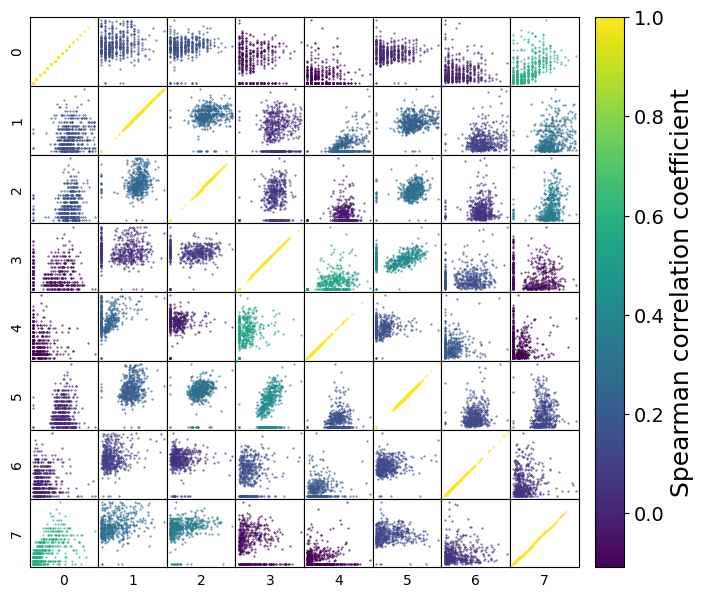

In [17]:
# This function is being imported from notebook_helper_functions.py
notebook_helper_functions.plot_scatter_matrix(training_features).show()

#### 3.3.2. Feature mutual information
Next, look at the relationship between each feature and the target. The higher the mutual information the stronger the relationship.

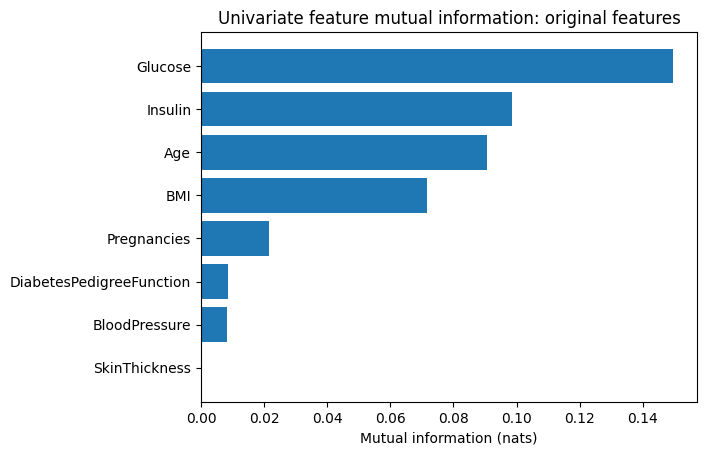

In [18]:
results=mutual_info_classif(training_features, training_labels)

univariate_mi_results={}

for feature, result in zip(training_features.columns, results):
    univariate_mi_results[feature]=result

univariate_mi_results=dict(sorted(univariate_mi_results.items(), key=lambda item: item[1]))

plt.title('Univariate feature mutual information: original features')

plt.barh(
    np.arange(len(univariate_mi_results.values())),
    univariate_mi_results.values(),
    tick_label=list(univariate_mi_results.keys())
)

plt.xlabel('Mutual information (nats)')

plt.show()

Based on the plots above, let's try using the following features - I'm excluding pregnancies the argument being this feature is invalid because we don't know the biological sex of the patient. Zero pregnancies for a female is one thing, but for a male? It's meaningless and we don't know which applies in each case.

In [19]:
manually_selected_feature_names=['Glucose','Insulin','BMI','Age']
manually_selected_training_features=training_features[manually_selected_feature_names]

In [20]:
# Run cross-validation
scores=cross_val_score(
    DecisionTreeClassifier(random_state=random_seed, class_weight=class_weights),
    manually_selected_training_features,
    training_labels,
    cv=cv_method,
    n_jobs=-1,
    scoring='accuracy'
)

# Collect the scores so we can plot and compare later
experiments['Manual feature selection']=scores * 100

print(f'Cross-validation accuracy: {(np.median(scores) * 100):.1f} +/- {(scores.std() * 100):.1f}%')

Cross-validation accuracy: 70.9 +/- 3.6%


Also a very small improvement.

### 3.4. Automated feature selection

Let's try some algorithmic methods for doing feature selection. Recursive feature elimination tries smaller and smaller subsets of features and measures the model's performance when trained on each subset to find the optimal number of features.

In [21]:
min_features_to_select=1
clf=DecisionTreeClassifier(random_state=random_seed)

rfecv=RFECV(
    estimator=model,
    step=1,
    cv=cv_method,
    scoring='accuracy',
    min_features_to_select=min_features_to_select,
    n_jobs=-1
)

rfecv.fit(training_features, training_labels)

print(f"Optimal number of features: {rfecv.n_features_}")

Optimal number of features: 4


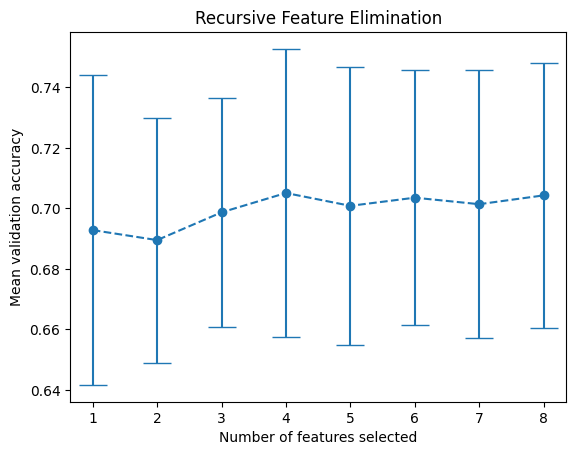

In [22]:
cv_results = pd.DataFrame(rfecv.cv_results_)
plt.figure()
plt.xlabel('Number of features selected')
plt.ylabel('Mean validation accuracy')
plt.errorbar(
    x=cv_results['n_features'],
    y=cv_results['mean_test_score'],
    yerr=cv_results['std_test_score'],
    capsize=10,
    marker='o',
    linestyle='dashed'
)
plt.title('Recursive Feature Elimination')
plt.show()

Not a striking difference between feature sets. They are all within a standard deviation of each other. Now let's recover the 'optimal' feature set and run cross validation on it to see how well it does compared to baseline.

In [23]:
automatically_selected_training_features=training_features.to_numpy()
automatically_selected_training_features=automatically_selected_training_features[:,rfecv.get_support()]

automatically_selected_feature_names=[b for a, b in zip(rfecv.get_support(), training_features.columns) if a]
automatically_selected_training_features=pd.DataFrame(data=automatically_selected_training_features, columns=automatically_selected_feature_names)
automatically_selected_training_features.head()

,Glucose,BloodPressure,BMI,Age
0,115.0,98.0,24.0,34.0
1,142.0,60.0,28.8,61.0
2,116.0,72.0,22.1,37.0
3,126.0,60.0,30.1,47.0
4,78.0,70.0,32.5,39.0


In [24]:
automatically_selected_training_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 514 entries, 0 to 513
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Glucose        514 non-null    float64
 1   BloodPressure  514 non-null    float64
 2   BMI            514 non-null    float64
 3   Age            514 non-null    float64
dtypes: float64(4)
memory usage: 16.2 KB


In [25]:
# Run cross-validation
scores=cross_val_score(
    DecisionTreeClassifier(random_state=random_seed, class_weight=class_weights),
    automatically_selected_training_features,
    training_labels,
    cv=cv_method,
    n_jobs=-1,
    scoring='accuracy'
)

# Collect the scores so we can plot and compare later
experiments['Automatic feature selection']=scores * 100

print(f'Cross-validation accuracy: {(np.median(scores) * 100):.1f} +/- {(scores.std() * 100):.1f}%')

Cross-validation accuracy: 71.2 +/- 4.8%


OK, slightly better than baseline.

### 3.5. Results

Let's take a look at how we are doing so far by plotting the cross-validation results we have collected from our experiments so far

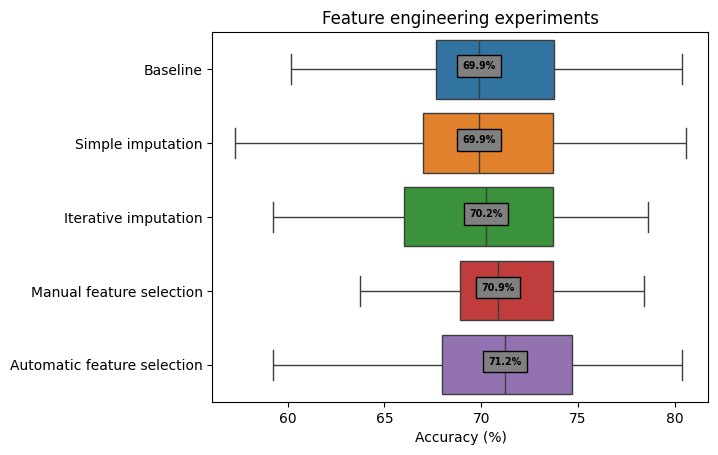

In [26]:
# This function is being imported from notebook_helper_functions.py
notebook_helper_functions.plot_cross_validation('Feature engineering experiments', experiments).show()

Looks like automatic feature selection is winning by a small margin. But, notice the width of the boxplots - none of these are a striking improvement over baseline.

### 3.6. Follow-up experiments

Just for fun, let's try some combinations of the above strategies before we move on. For example, what happens if we do imputation and then feature selection?

#### 3.6.1. Impute, then select features

In [27]:
# Do the feature selection on the imputed features
min_features_to_select=1
clf=DecisionTreeClassifier(random_state=random_seed)

rfecv=RFECV(
    estimator=model,
    step=1,
    cv=cv_method,
    scoring='accuracy',
    min_features_to_select=min_features_to_select,
    n_jobs=-1
)

rfecv.fit(iterative_imputed_training_features, training_labels)

print(f"Optimal number of features: {rfecv.n_features_}")

Optimal number of features: 6


In [28]:
# Recover the 'optimal' feature set
automatically_selected_imputed_training_features=iterative_imputed_training_features.to_numpy()
automatically_selected_imputed_training_features=automatically_selected_imputed_training_features[:,rfecv.get_support()]

automatically_selected_imputed_feature_names=[b for a, b in zip(rfecv.get_support(), iterative_imputed_training_features.columns) if a]
automatically_selected_imputed_training_features=pd.DataFrame(data=automatically_selected_imputed_training_features, columns=automatically_selected_imputed_feature_names)
automatically_selected_imputed_training_features.head()

,Glucose,BloodPressure,SkinThickness,BMI,DiabetesPedigreeFunction,Age
0,115.0,98.0,31.727114,24.0,1.022,34.0
1,142.0,60.0,33.000000,28.8,0.687,61.0
2,116.0,72.0,12.000000,22.1,0.463,37.0
3,126.0,60.0,28.379307,30.1,0.349,47.0
4,78.0,70.0,41.000000,32.5,0.270,39.0


In [29]:
# Run cross-validation
scores=cross_val_score(
    DecisionTreeClassifier(random_state=random_seed, class_weight=class_weights),
    automatically_selected_imputed_training_features,
    training_labels,
    cv=cv_method,
    n_jobs=-1,
    scoring='accuracy'
)

# Collect the scores so we can plot and compare later
experiments['Iterative imputation,\nfeature selection']=scores * 100

print(f'Cross-validation accuracy: {(np.median(scores) * 100):.1f} +/- {(scores.std() * 100):.1f}%')

Cross-validation accuracy: 69.9 +/- 4.8%


Nice - that's the best score we have seen so far! What if we try it the other way around?

#### 3.6.2. Select features, then impute

In [30]:
# First, we need a new missing data features list that contains only
# missing data features which were selected by the recursive feature elimination
automatically_selected_missing_data_features=[]

for feature in missing_data_features:
    if feature in automatically_selected_training_features.columns:
        automatically_selected_missing_data_features.append(feature)

imputed_automatically_selected_training_features, automatically_selected_features_imp, automatically_selected_features_qt=notebook_helper_functions.impute(
    automatically_selected_training_features, 
    automatically_selected_missing_data_features
)

[IterativeImputer] Completing matrix with shape (514, 4)
[IterativeImputer] Completing matrix with shape (514, 4)


In [31]:
# Run cross-validation
scores=cross_val_score(
    DecisionTreeClassifier(random_state=random_seed, class_weight=class_weights),
    imputed_automatically_selected_training_features,
    training_labels,
    cv=cv_method,
    n_jobs=-1,
    scoring='accuracy'
)

# Collect the scores so we can plot and compare later
experiments['Feature selection,\niterative imputation']=scores * 100

print(f'Cross-validation accuracy: {(np.median(scores) * 100):.1f} +/- {(scores.std() * 100):.1f}%')

Cross-validation accuracy: 71.4 +/- 5.1%


Interesting - no real improvement over baseline. Let's summarize our results so far.

### 3.7. Follow-up results

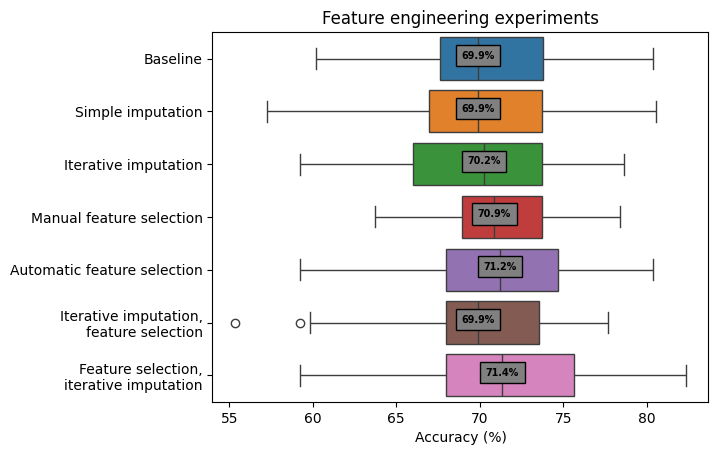

In [32]:
notebook_helper_functions.plot_cross_validation('Feature engineering experiments', experiments).show()

Manual feature selection seems to have worked the best. Let's carry forward that data for the rest of the notebook.

In [33]:
# Pick the feature set we want to use for hyperparameter tuning
hyperparameter_tuning_features=iterative_imputed_training_features[manually_selected_feature_names]
hyperparameter_tuning_features.head()

,Glucose,Insulin,BMI,Age
0,115.0,76.004663,24.0,34.0
1,142.0,190.000000,28.8,61.0
2,116.0,87.000000,22.1,37.0
3,126.0,160.467432,30.1,47.0
4,78.0,143.261226,32.5,39.0


## 3. Hyperparameter optimization

Let's try doing this in two stages - first we will try out *criterion*, *splitter* and *class_weight*. These are choices between a few alternative options. Once we have the best combination for this dataset we will do a second round for hyperparameters like *tree_dept* which are int or float.

In [34]:
# Start new results holder for hyperparameter optimization results
hyperparameter_experiments={
    'Baseline': experiments['Baseline'],
    'Iterative imputation,\nfeature selection': experiments['Iterative imputation,\nfeature selection']
}

### 3.1. Criterion, splitter & class_weight

In [35]:
model=DecisionTreeClassifier(random_state=random_seed)

distributions={
    'criterion': ['gini', 'entropy', 'log_loss'],
    'splitter': ['best', 'random'],
    'class_weight': [None, 'balanced']
}

grid=GridSearchCV(
    model,
    distributions,
    scoring='accuracy',
    n_jobs=-1,
    cv=cv_method,
    return_train_score=True
)

round_one_results=grid.fit(hyperparameter_tuning_features, training_labels)
print(f'Best hyperparameters: {round_one_results.best_params_}')

Best hyperparameters: {'class_weight': 'balanced', 'criterion': 'gini', 'splitter': 'best'}


For reference, here are the **[Scikit-learn defaults](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)**:

1. criterion='gini'
2. splitter='best'
3. class_weight=None

So the optimization chose the default values for criterion and splitter, but balanced class weighting worked better than the default value of none. We can also plot the performance of each condition the grid search sampled to see the range of accuracy scores:

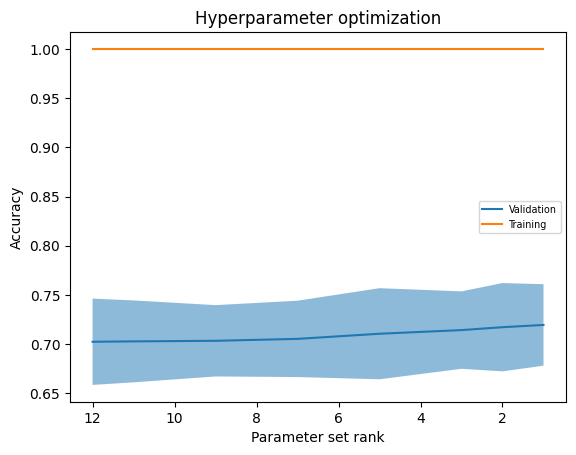

In [39]:
notebook_helper_functions.plot_hyperparameter_tuning(round_one_results).show()

So the worst parameter sets give ~70% on the validation set, while the best give ~ 72 or 73%. Let's cross-validate the model using the winning parameter settings:

In [40]:
# Instantiate a model using the winning parameters
model=DecisionTreeClassifier(
    class_weight=round_one_results.best_params_['class_weight'],
    criterion=round_one_results.best_params_['criterion'],
    splitter=round_one_results.best_params_['splitter'],
    random_state=random_seed
)

# Run cross-validation on the best model
scores=cross_val_score(
    model,
    hyperparameter_tuning_features,
    training_labels,
    cv=cv_method,
    n_jobs=-1,
    scoring='accuracy'
)

# Collect the scores so we can plot and compare later
hyperparameter_experiments['Hyperparameter\noptimization\nround 1']=scores * 100
print(f'Cross-validation accuracy: {(np.median(scores) * 100):.1f} +/- {(scores.std() * 100):.1f}%')

Cross-validation accuracy: 71.8 +/- 4.1%


Definitely better than baseline - but the hyperparameter optimization did not contribute that much over the improvement offered by the feature engineering alone.

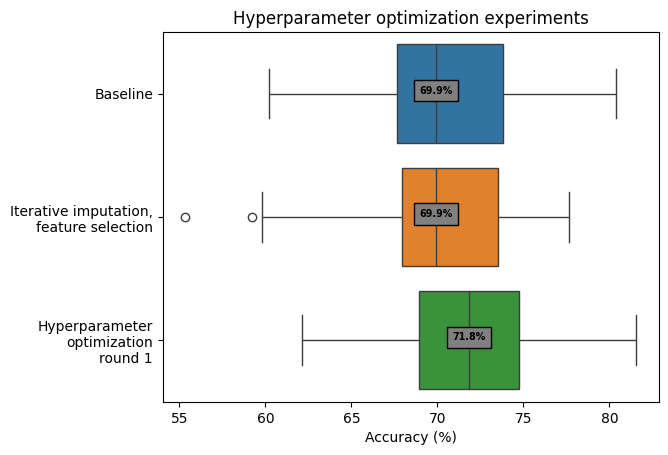

In [41]:
notebook_helper_functions.plot_cross_validation('Hyperparameter optimization experiments', hyperparameter_experiments).show()

### 3.2: Other hyperparameters

In [ ]:
# Instantiate a model using the winning parameters from the first round
# of hyperparameter optimization
model=DecisionTreeClassifier(
    class_weight=round_one_results.best_params_['class_weight'],
    criterion=round_one_results.best_params_['criterion'],
    splitter=round_one_results.best_params_['splitter'],
    random_state=random_seed
)

distributions={
    'max_depth': randint(1, 51),
    'min_samples_split': randint(5, 51),
    'min_samples_leaf': randint(5, 51),
    'min_weight_fraction_leaf': uniform(loc=0.0, scale=0.5),
    'min_impurity_decrease': uniform(loc=0.0, scale=0.5)
}

grid=RandomizedSearchCV(
    model,
    distributions,
    scoring='accuracy',
    n_jobs=-1,
    cv=cv_method,
    n_iter=5000,
    random_state=random_seed,
    return_train_score=True
)

round_two_results=grid.fit(hyperparameter_tuning_features, training_labels)
print(f'Best hyperparameters: {results.best_params_}')

In [ ]:
plot_hyperparameter_tuning(round_two_results).show()

In [ ]:
# Instantiate a model using the winning parameters
model=DecisionTreeClassifier(
    class_weight=round_one_results.best_params_['class_weight'],
    criterion=round_one_results.best_params_['criterion'],
    splitter=round_one_results.best_params_['splitter'],
    max_depth=round_two_results.best_params_['max_depth'],
    min_impurity_decrease=round_two_results.best_params_['min_impurity_decrease'],
    min_samples_leaf=round_two_results.best_params_['min_samples_leaf'],
    min_samples_split=round_two_results.best_params_['min_samples_split'],
    min_weight_fraction_leaf=round_two_results.best_params_['min_weight_fraction_leaf']
)

# Run cross-validation on the best model
scores=cross_val_score(
    model,
    hyperparameter_tuning_features,
    training_labels,
    cv=cv_method,
    n_jobs=-1,
    scoring='accuracy'
)

# Collect the scores so we can plot and compare later
hyperparameter_experiments['Hyperparameter\noptimization\nround 2']=scores * 100

print(f'Cross-validation accuracy: {(np.median(scores) * 100):.1f} +/- {(scores.std() * 100):.1f}%')

In [ ]:
plot_cross_validation('Hyperparameter optimization experiments', hyperparameter_experiments).show()

In [ ]:
# Finally, train the model on all of the training data at once
model=DecisionTreeClassifier(
    class_weight=round_one_results.best_params_['class_weight'],
    criterion=round_one_results.best_params_['criterion'],
    splitter=round_one_results.best_params_['splitter'],
    max_depth=round_two_results.best_params_['max_depth'],
    min_impurity_decrease=round_two_results.best_params_['min_impurity_decrease'],
    min_samples_leaf=round_two_results.best_params_['min_samples_leaf'],
    min_samples_split=round_two_results.best_params_['min_samples_split'],
    min_weight_fraction_leaf=round_two_results.best_params_['min_weight_fraction_leaf']
)

fit_result=model.fit(hyperparameter_tuning_features, training_labels)

## 4. Evaluation

Now it's finally time to see how well the model does on the test data. We should only do this **ONCE**, and we should only do it **AFTER** we have made our final decision about how to prepare the data. If we look at the test data performance and then go back and change our feature engineering to improve it - the result no-longer represents an estimate of the model's performance on 'unseen' test data and therefore is not a true evaluation.

### 4.1. Evaluate the model's performance on the test data

In [ ]:
# Get features and labels
testing_labels=testing_df['Outcome']
testing_features=testing_df.drop('Outcome', axis=1)

In [ ]:
# Use the quantile transformer and imputer that we fit on the training data to transform the testing data

# Save the feature names for later - the imputer will return a numpy array
# and we might like to get out Pandas dataframe back
feature_names=list(testing_features.columns)

# Make a copy of the testing features
imputed_testing_features=testing_features.copy()
imputed_testing_features[missing_data_features]=imputed_testing_features[missing_data_features].replace({0:np.nan})

# Quantile transform our features - this is for the imputer, not the decision tree
imputed_testing_features[missing_data_features]=qt.transform(imputed_testing_features[missing_data_features])

# Run the imputation
imputed_testing_features=imp.transform(imputed_testing_features)

# Convert back to pandas
indicator_features=[]
for feature in missing_data_features:
    indicator_features.append(f'{feature}_indicator')

feature_names.extend(indicator_features)
imputed_testing_features=pd.DataFrame(data=imputed_testing_features, columns=feature_names)

# Now that zeros have been replaces - undo the quantile transformation.
# This way we are training the model on un-altered values. This way,
# during deployment, we don't have to worry about transforming the input data.
imputed_testing_features[missing_data_features]=qt.inverse_transform(imputed_testing_features[missing_data_features])
imputed_testing_features.head()

In [ ]:
# Get only the selected features from the testing data, using the list
# determined during the feature selection on the training data
selected_imputed_testing_features=imputed_testing_features[manually_selected_feature_names]
selected_imputed_testing_features.head()

In [ ]:
# Make predictions from test set features
predicted_labels=model.predict(selected_imputed_testing_features)

# Score predictions from accuracy
percent_accuracy=accuracy_score(testing_labels, predicted_labels) * 100
print(f'Model is {percent_accuracy:.1f}% accurate on the test data')

This is a pretty good result - not because it is a super high accuracy score - but instead because we were very close to being right about how accurate the model would be on the test data! Also, we did manage to improve the baseline result by a few percentage points.

### 4.1. Save assets for later deployment

In [ ]:
# Save the model
model_output_file='../models/model.pkl'

with open(model_output_file, 'wb') as output_file:
    pickle.dump(model, output_file, protocol=pickle.HIGHEST_PROTOCOL)

# Save the quantile transformer
quantile_transformer_output_file='../models/quantile_transformer.pkl'

with open(quantile_transformer_output_file, 'wb') as output_file:
    pickle.dump(qt, output_file, protocol=pickle.HIGHEST_PROTOCOL)

# Save the imputation model
imputer_output_file='../models/imputer.pkl'

with open(imputer_output_file, 'wb') as output_file:
    pickle.dump(imp, output_file, protocol=pickle.HIGHEST_PROTOCOL)